### **Calculando features e indicadores técnicos para cada ação**

In [23]:
# Importando bibliotecas necessárias
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

warnings.filterwarnings('ignore')

b3 = pd.read_html('https://www.dadosdemercado.com.br/bolsa/acoes')[0]
b3['Ticker'] = b3['Ticker'] + '.SA'
data_final = '2024-03-11'
data_inicial = pd.to_datetime(data_final) - pd.DateOffset(365*10)
lista_tickers = b3['Ticker'].unique().tolist()

df = yf.download(tickers=lista_tickers,
                 start=data_inicial,
                 end=data_final).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%%**********************]  533 of 533 completed

73 Failed downloads:
['SULA4.SA', 'GETT3.SA', 'CEPE6.SA', 'BOAS3.SA', 'BLUT3.SA', 'APTI4.SA', 'CESP5.SA', 'TESA3.SA', 'SMLS3.SA', 'HGTX3.SA', 'CESP3.SA', 'DMMO3.SA', 'VIIA3.SA', 'BRDT3.SA', 'MOSI3.SA', 'GETT4.SA', 'WIZS3.SA', 'BIDI4.SA', 'BTOW3.SA', 'LAME3.SA', 'GNDI3.SA', 'PNVL4.SA', 'TIET4.SA', 'CEPE3.SA', 'POWE3.SA', 'IGTA3.SA', 'VVAR3.SA', 'BPAR3.SA', 'BRML3.SA', 'TCNO4.SA', 'CALI4.SA', 'BSEV3.SA', 'DTEX3.SA', 'CSAB4.SA', 'TCNO3.SA', 'CARD3.SA', 'CRDE3.SA', 'CSAB3.SA', 'MTIG4.SA', 'MODL4.SA', 'SQIA3.SA', 'EEEL3.SA', 'LAME4.SA', 'CNTO3.SA', 'GPCP3.SA', 'ALSO3.SA', 'TIET3.SA', 'MEGA3.SA', 'OMGE3.SA', 'PARD3.SA', 'JBDU4.SA', 'EEEL4.SA', 'LCAM3.SA', 'BIDI3.SA', 'CESP6.SA', 'LLIS3.SA', 'CEPE5.SA', 'BTTL3.SA', 'MODL3.SA', 'CCPR3.SA', 'JPSA3.SA', 'BLUT4.SA', 'FNCN3.SA', 'JBDU3.SA', 'BBRK3.SA', 'GPCP4.SA', 'SULA3.SA', 'MMXM3.SA', 'ENBR3.SA', 'LINX3.SA', 'BKBR3.SA']: Exception('%ticker%: No timezone found, symbol may 

In [143]:
# Volatilidade de German-Klass (incorpora preço máximo, mínimo e preço de fechamento do dia)
df['german_klass_vol'] = ((np.log(df['high']) - np.log(df['low'])) ** 2)/2 - (2*np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def calcular_atr(dados_acao):
    
    atr = pandas_ta.atr(high=dados_acao['high'],
                        low=dados_acao['low'],
                        close=dados_acao['close'],
                        length=14)
    
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(calcular_atr) 

def calcular_macd(close):
    macd_result = pandas_ta.macd(close=close, fast=12, slow=26, signal=9)

    if macd_result is not None and len(macd_result.columns) > 0:
        
        macd = macd_result.iloc[:, 0] 
        
        return macd.sub(macd.mean()).div(macd.std())
    else:

        return pd.Series([np.nan] * len(close), index=close.index)


df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(calcular_macd)

df['volume_em_real'] = (df['adj close'] * df['volume']) / 1e6

### Agrupando por mês e filtrando as ações com mais liquidez

In [144]:
last_cols = [c for c in df.columns.unique(0) if c not in ['volume_em_real', 'volume', 'open', 
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['volume_em_real'].resample('M').mean().stack('ticker').to_frame('volume_em_real'), 
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 46085 entries, (Timestamp('2014-04-30 00:00:00'), 'ABCB4.SA') to (Timestamp('2024-03-31 00:00:00'), 'ALOS3.SA')
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volume_em_real    46085 non-null  float64
 1   adj close         46085 non-null  float64
 2   atr               46085 non-null  float64
 3   bb_high           46085 non-null  float64
 4   bb_low            46085 non-null  float64
 5   bb_mid            46085 non-null  float64
 6   german_klass_vol  46085 non-null  float64
 7   macd              46085 non-null  float64
 8   rsi               46085 non-null  float64
dtypes: float64(9)
memory usage: 3.3+ MB


In [146]:
data['volume_em_real'] = (data.loc[:, 'volume_em_real'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['volume_rank'] = (data.groupby('date')['volume_em_real'].rank(ascending=False))

data = data[data['volume_rank']<150].drop(['volume_em_real', 'volume_rank'], axis=1)

In [147]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                        
2015-03-31 ABCB4.SA   4.671685 -1.322075  1.773016  1.687227  1.730121   
           ABEV3.SA  13.492869  0.131842  2.692376  2.638212  2.665294   
           ALPA4.SA   6.565410 -0.908305  2.072157  1.908825  1.990491   
           AMAR3.SA  58.367142  0.584090  4.139271  4.032929  4.086100   
           AMER3.SA  18.946627 -0.292186  3.069593  2.819344  2.944469   
...                        ...       ...       ...       ...       ...   
2024-03-31 TTEN3.SA  10.570000 -1.404578  2.501059  2.313489  2.407274   
           RAIZ4.SA   3.480000 -1.417878  1.615348  1.485523  1.550436   
           ONCO3.SA  10.340000 -0.432550  2.483643  2.361661  2.422652   
           SRNA3.SA   8.450000 -0.071700  2.460026  2.219621  2.339823   
           AURE3.SA  12.150000 -1.403434  2.627841  2.571399  2.599620   

                     german_klass_vol      macd        rsi  
date       ticker                                           
2015-03-31 ABCB4.SA         -0.130013 -0.340483  47.542380  
           ABEV3.SA         -0.037045  0.512552  56.416676  
           ALPA4.SA         -0.011587  0.344304  68.120087  
           AMAR3.SA          0.000250 -0.376574  47.797601  
           AMER3.SA          0.006158 -0.317420  51.255405  
...                               ...       ...        ...  
2024-03-31 TTEN3.SA          0.000387  0.255613  51.198752  
           RAIZ4.SA          0.000379 -0.478656  36.804693  
           ONCO3.SA          0.000347 -0.557479  45.145251  
           SRNA3.SA          0.002072 -1.243368  35.969879  
           AURE3.SA          0.000062 -1.028438  39.903954  

[16241 rows x 8 columns]

In [148]:
def calcular_retornos(df):
    
    corte_outlier = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(corte_outlier),
                                                       upper=x.quantile(1-corte_outlier)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    
    return df
        
        
data = data.groupby(level=1, group_keys=False).apply(calcular_retornos).dropna()

### Três e cinco fatores de Fama e French e calculo dos betas dos fatores

In [149]:
fatores_brasil = pd.read_csv('https://nefin.com.br/resources/risk_factors/nefin_factors.csv', usecols=['Date','Rm_minus_Rf', 'SMB', 'HML', 'WML', 'IML'],)
fatores_brasil.set_index('Date', inplace=True)
fatores_brasil.columns = fatores_brasil.columns.str.lower()
fatores_brasil.index = pd.to_datetime(fatores_brasil.index)
fatores_brasil = fatores_brasil[fatores_brasil.index.year >= 2010]
fatores_brasil = fatores_brasil.resample('M').last()
fatores_brasil.index.name = 'date'
factor_data = fatores_brasil.join(data['return_1m'], how='left').sort_index()


In [150]:
# Filtrando ações com menos de 10 meses de dados

obs = factor_data.groupby(level=1).size()

acoes_validas = obs[obs >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(acoes_validas.index)]

In [151]:
# Calculando os betas dos fatores

betas = (factor_data.groupby(level=1,
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns) + 1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

rm_minus_rf       smb       hml       wml       iml
date       ticker                                                       
2016-03-31 ABCB4.SA          NaN       NaN       NaN       NaN       NaN
           ABEV3.SA          NaN       NaN       NaN       NaN       NaN
           ALPA4.SA          NaN       NaN       NaN       NaN       NaN
           AMAR3.SA          NaN       NaN       NaN       NaN       NaN
           AMER3.SA          NaN       NaN       NaN       NaN       NaN
...                          ...       ...       ...       ...       ...
2024-03-31 VIVT3.SA     4.041957  0.621210  0.188237  1.220538  4.902257
           WEGE3.SA     3.521137 -0.555604  1.075660 -2.154687  5.090992
           WIZC3.SA     3.986141 -2.461235 -0.200676  1.189717  1.433889
           YDUQ3.SA     3.956802  3.241991  4.580282 -5.319765  7.245268
           ZAMP3.SA    -0.456038  3.106752 -3.445870  3.332585 -1.386189

[13446 rows x 5 columns]

In [152]:
fatores = list(fatores_brasil.columns)
data = (data.join(betas.groupby('ticker').shift()))
data.loc[:, fatores] = data.groupby('ticker', group_keys=False)[fatores].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()


In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12894 entries, (Timestamp('2016-03-31 00:00:00'), 'ABCB4.SA') to (Timestamp('2024-03-31 00:00:00'), 'LWSA3.SA')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               12894 non-null  float64
 1   bb_high           12894 non-null  float64
 2   bb_low            12894 non-null  float64
 3   bb_mid            12894 non-null  float64
 4   german_klass_vol  12894 non-null  float64
 5   macd              12894 non-null  float64
 6   rsi               12894 non-null  float64
 7   return_1m         12894 non-null  float64
 8   return_2m         12894 non-null  float64
 9   return_3m         12894 non-null  float64
 10  return_6m         12894 non-null  float64
 11  return_9m         12894 non-null  float64
 12  return_12m        12894 non-null  float64
 13  rm_minus_rf       12894 non-null  float64
 14  smb               12894 non-null  float64
 15  h

### Criando o modelo 

In [154]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state= 0,
                           init=initial_centroids).fit(df).labels_
    
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12894 entries, (Timestamp('2016-03-31 00:00:00'), 'ABCB4.SA') to (Timestamp('2024-03-31 00:00:00'), 'LWSA3.SA')
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               12894 non-null  float64
 1   bb_high           12894 non-null  float64
 2   bb_low            12894 non-null  float64
 3   bb_mid            12894 non-null  float64
 4   german_klass_vol  12894 non-null  float64
 5   macd              12894 non-null  float64
 6   rsi               12894 non-null  float64
 7   return_1m         12894 non-null  float64
 8   return_2m         12894 non-null  float64
 9   return_3m         12894 non-null  float64
 10  return_6m         12894 non-null  float64
 11  return_9m         12894 non-null  float64
 12  return_12m        12894 non-null  float64
 13  rm_minus_rf       12894 non-null  float64
 14  smb               12894 non-null  float64
 15  h

In [156]:
def plotar_clusters(data):
    
    cluster_0 = data[data['cluster'] == 1]
    cluster_1 = data[data['cluster'] == 2]
    cluster_2 = data[data['cluster'] == 3]
    cluster_3 = data[data['cluster'] == 4]
    
    plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 6], color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 6], color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 6], color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 6], color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    
    return

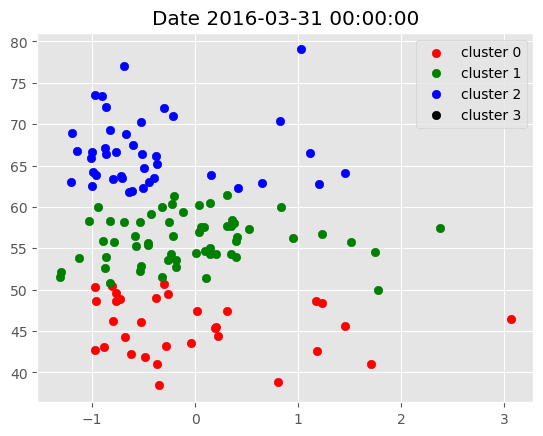

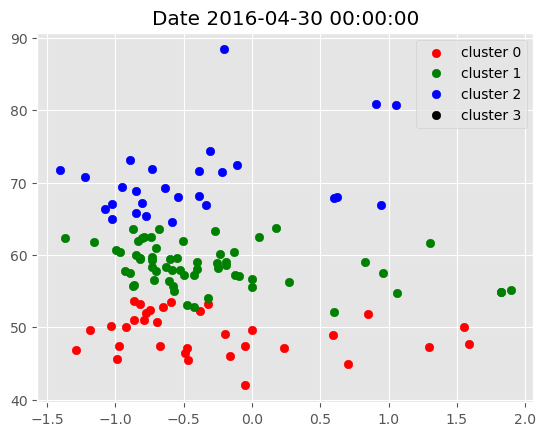

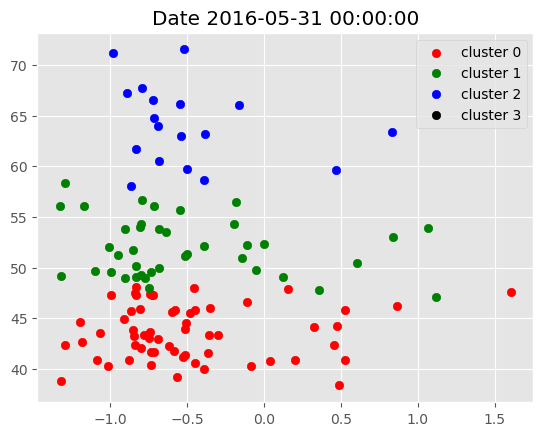

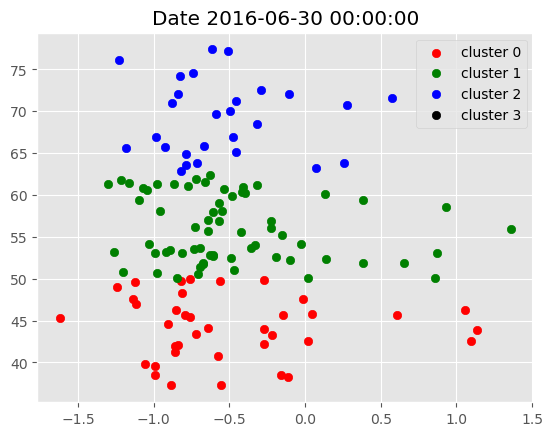

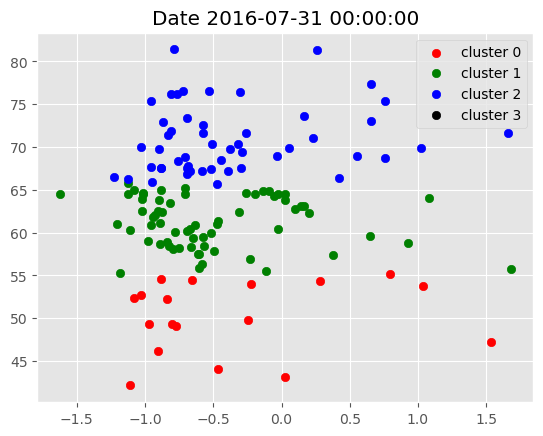

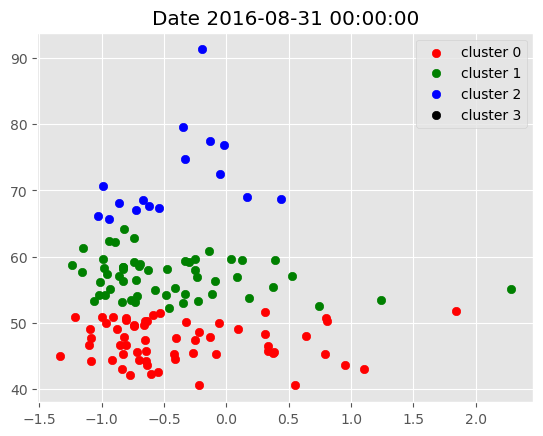

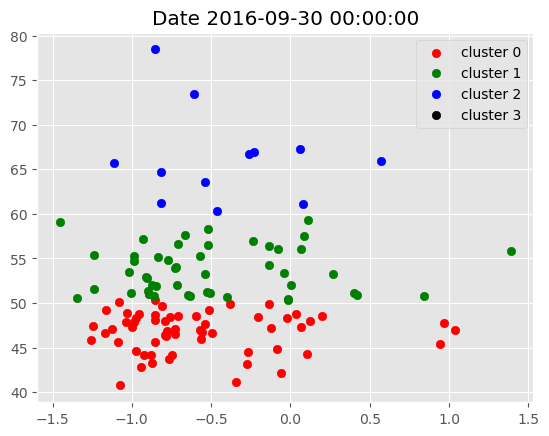

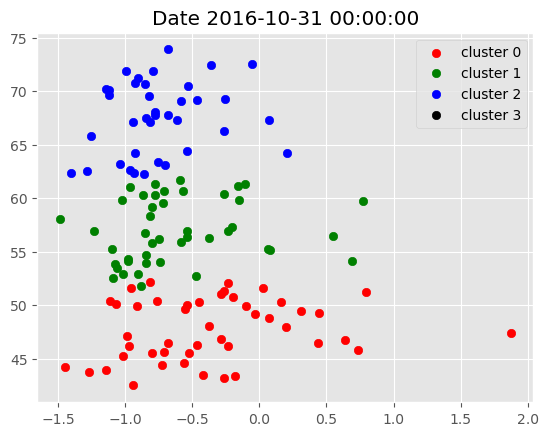

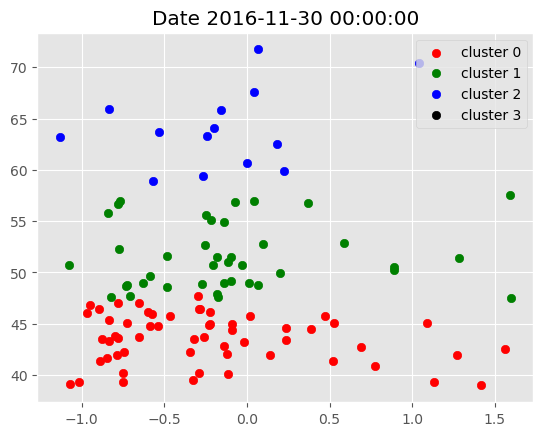

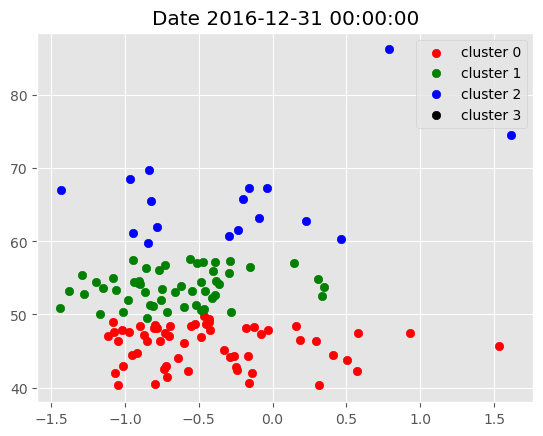

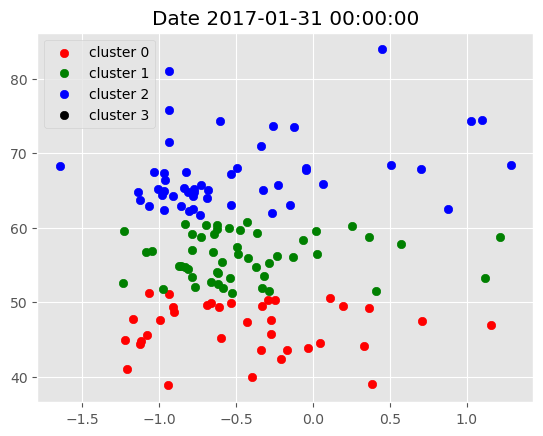

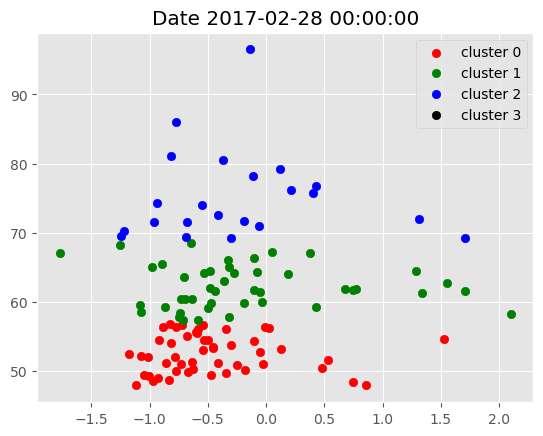

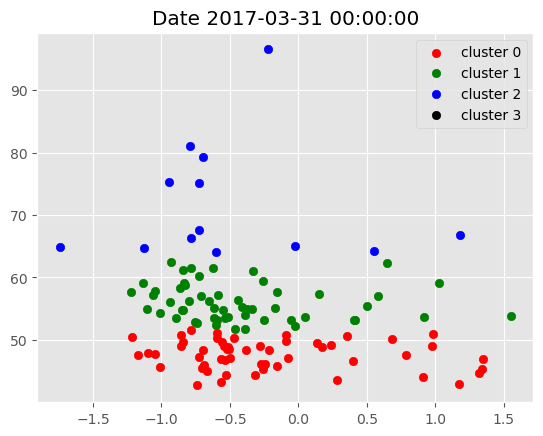

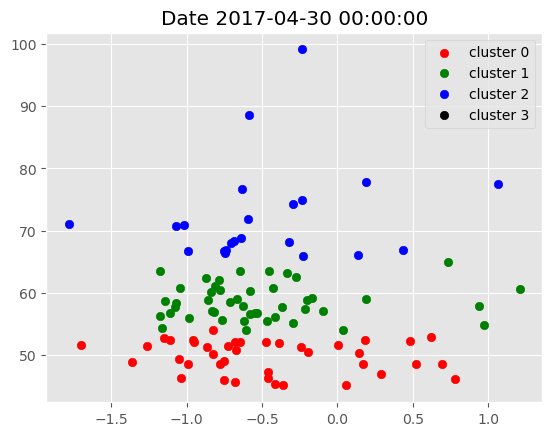

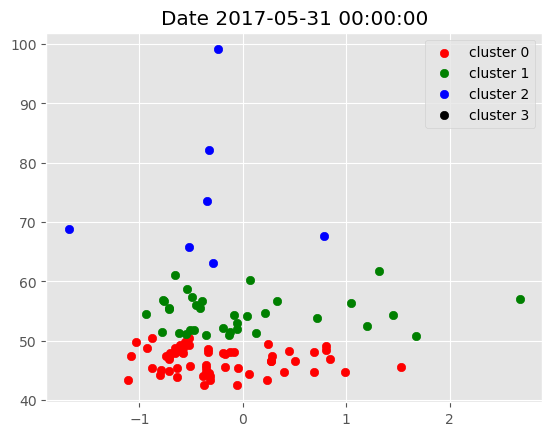

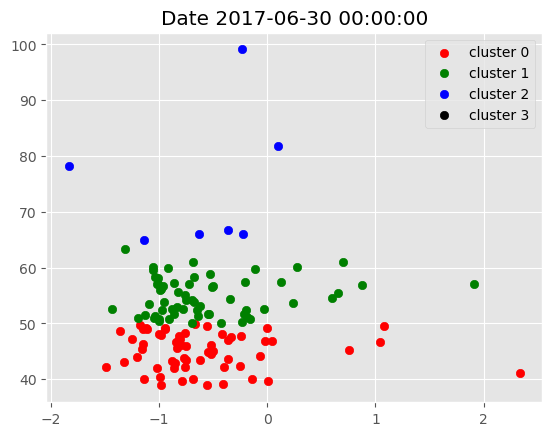

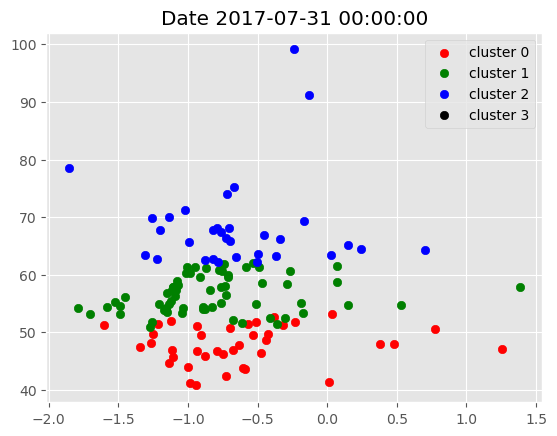

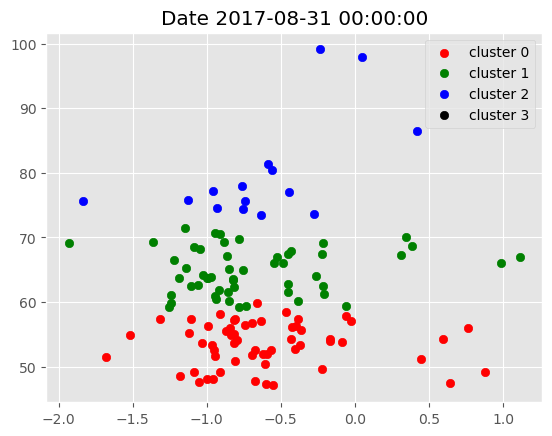

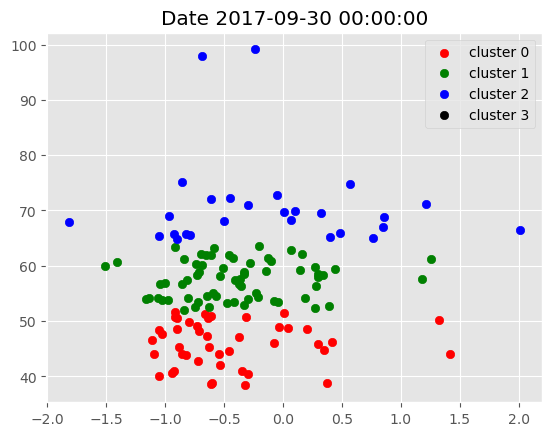

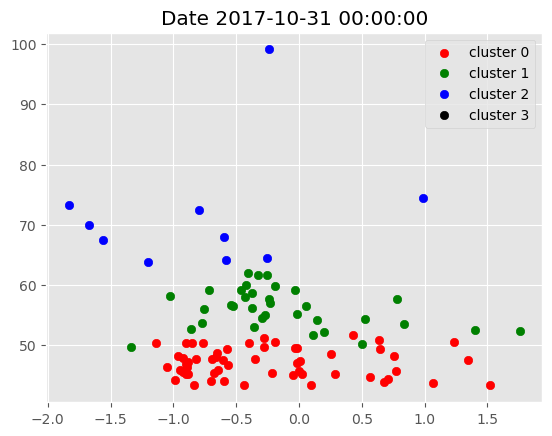

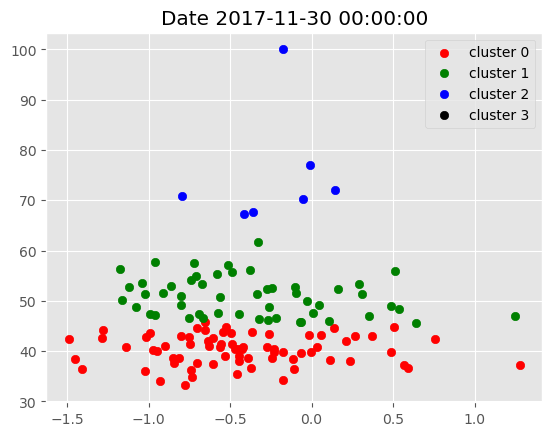

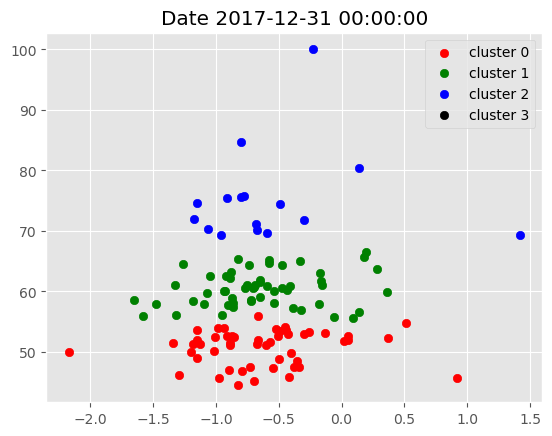

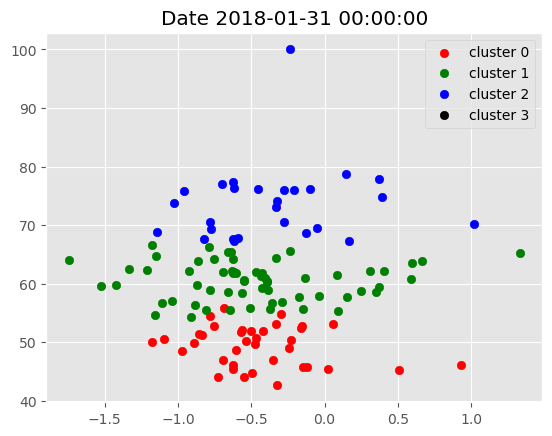

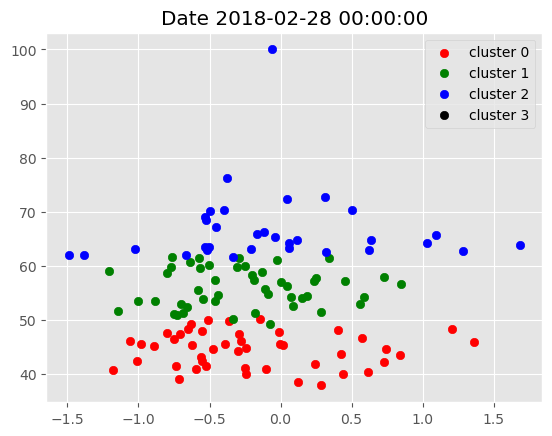

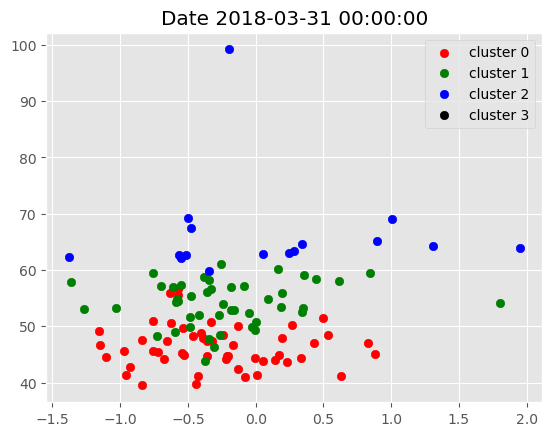

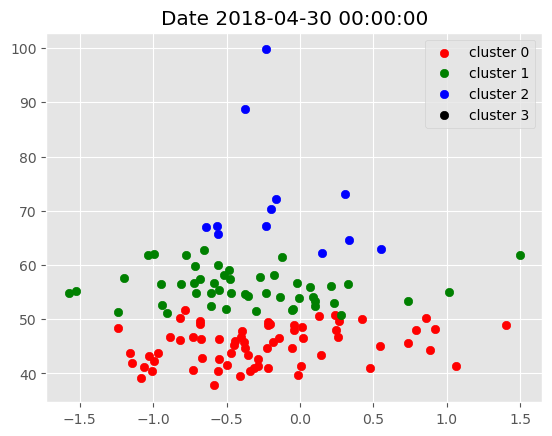

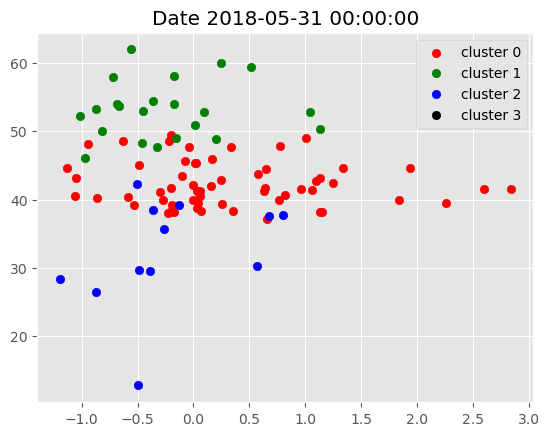

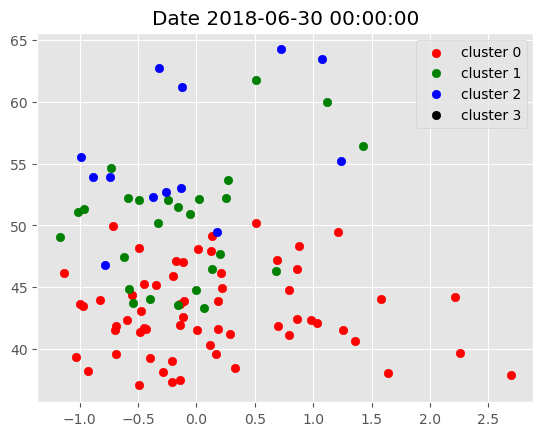

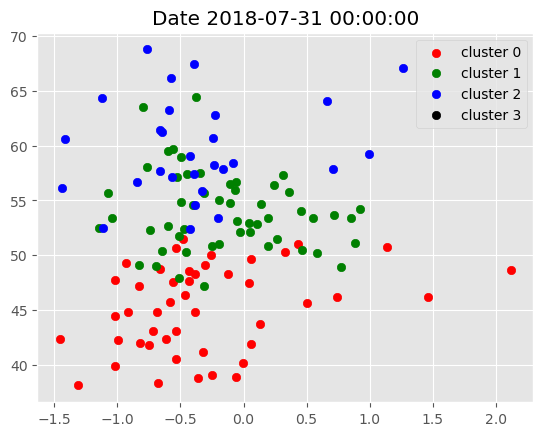

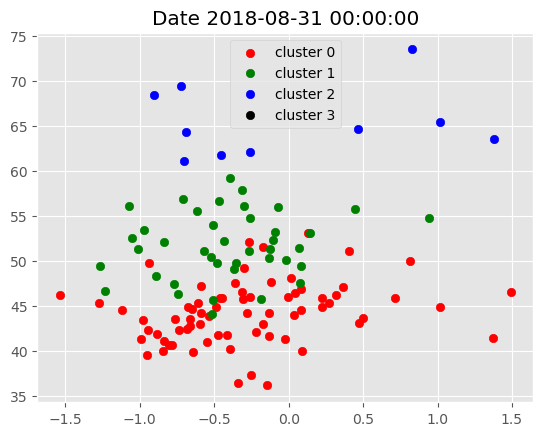

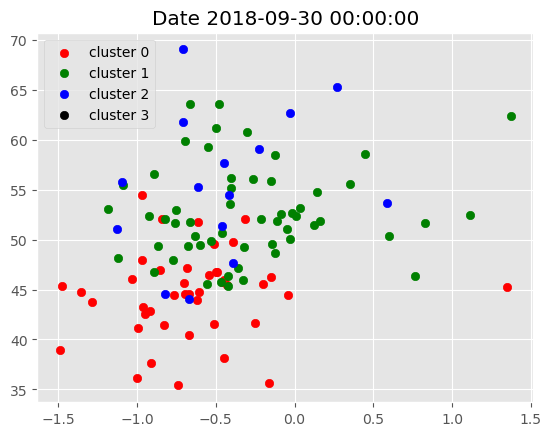

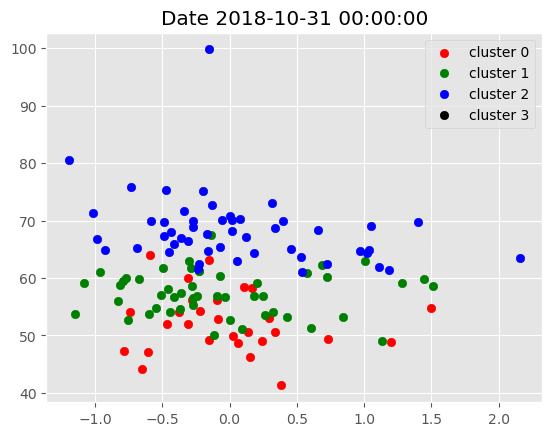

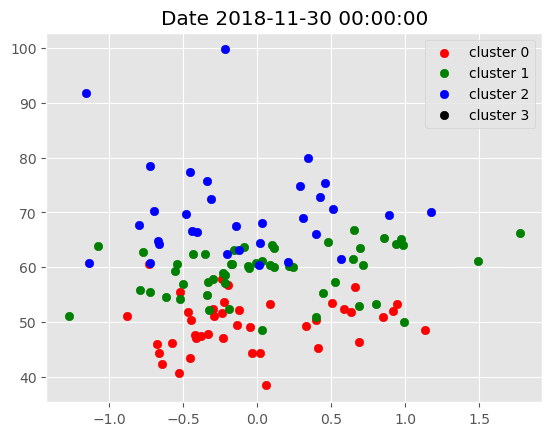

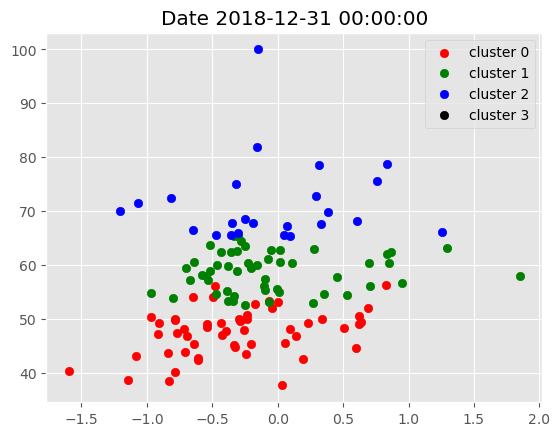

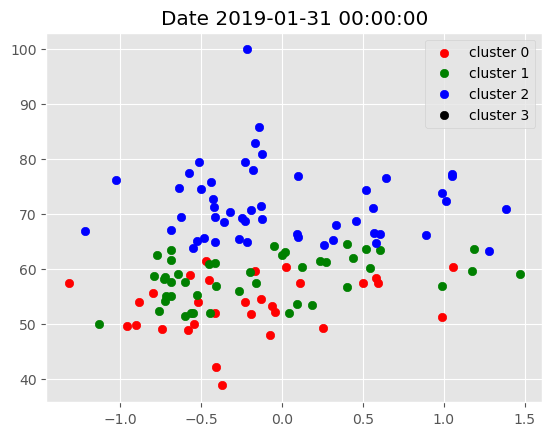

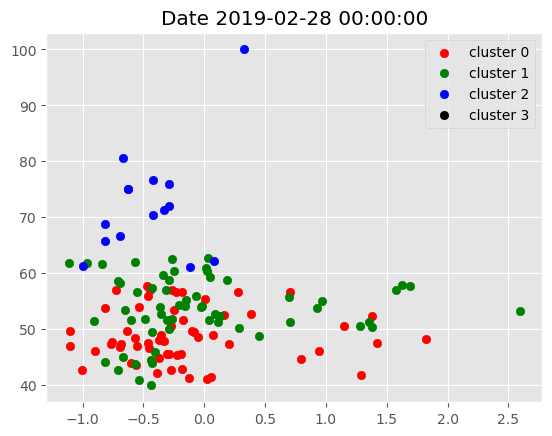

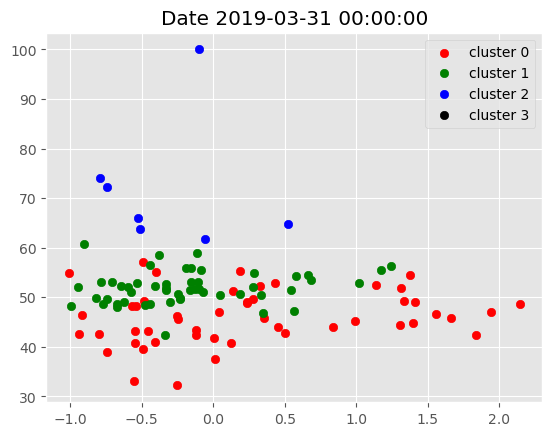

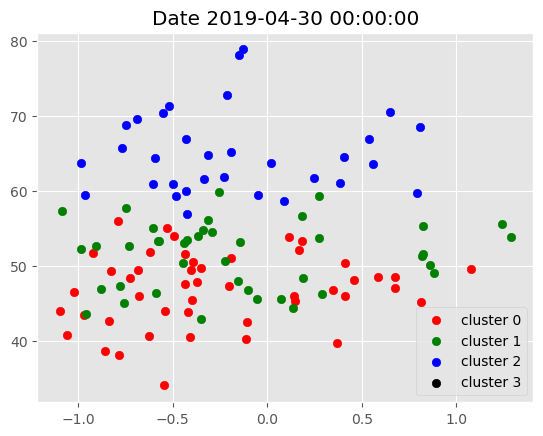

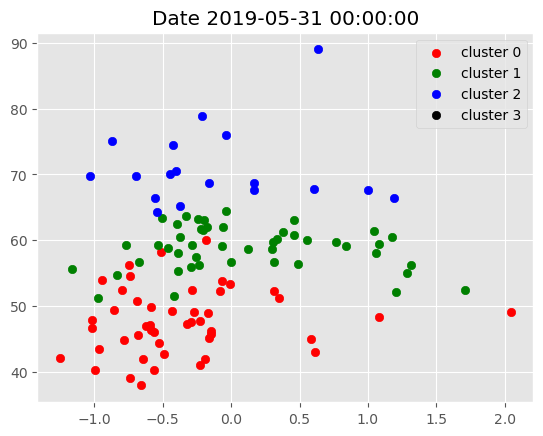

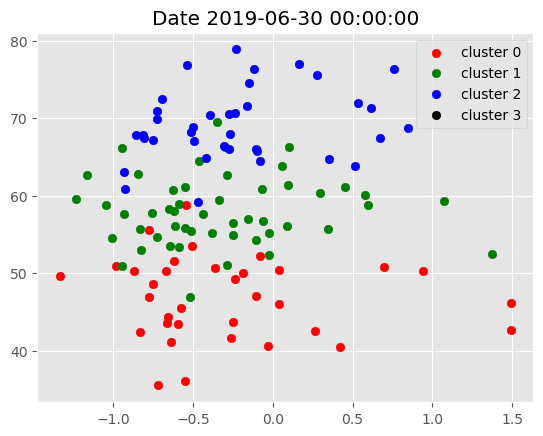

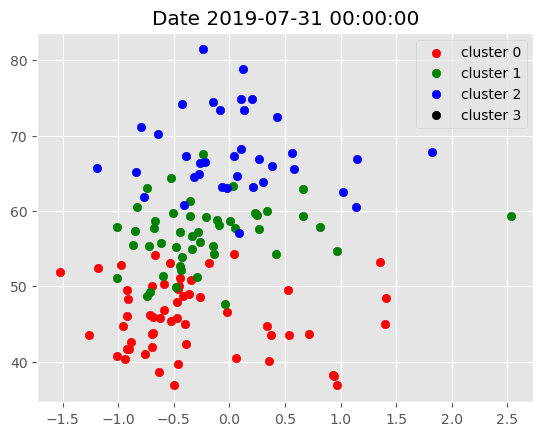

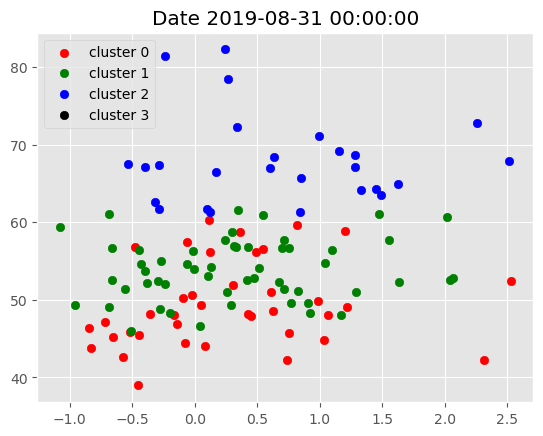

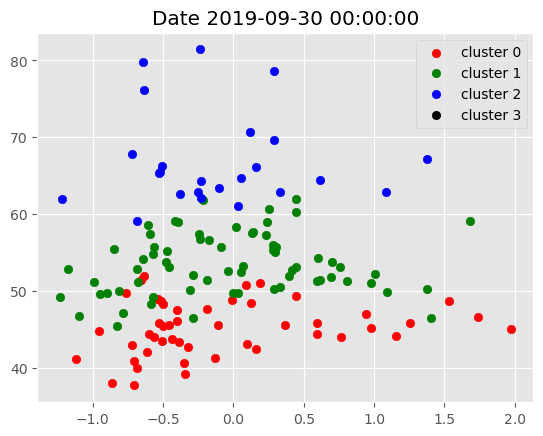

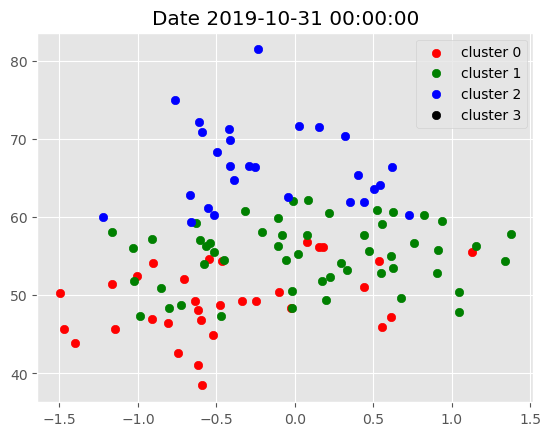

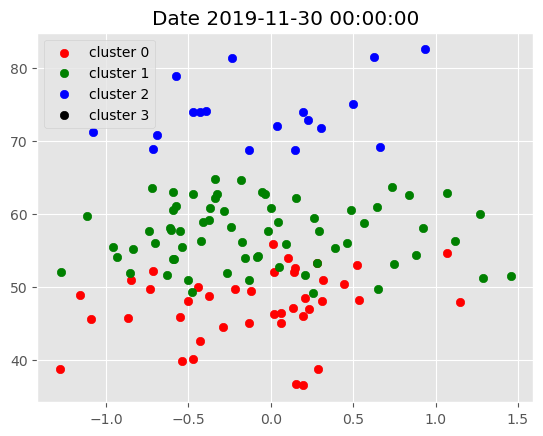

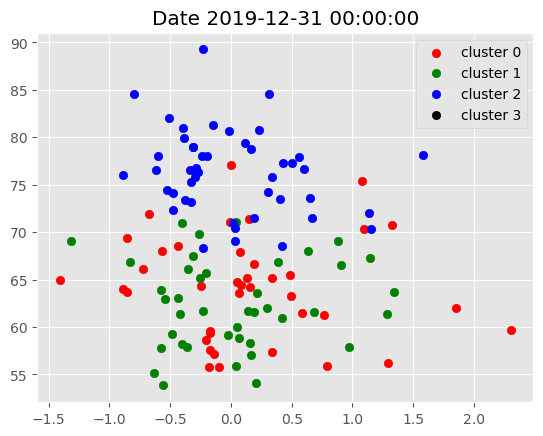

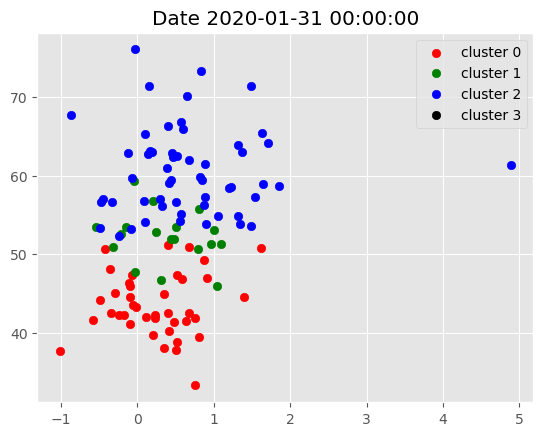

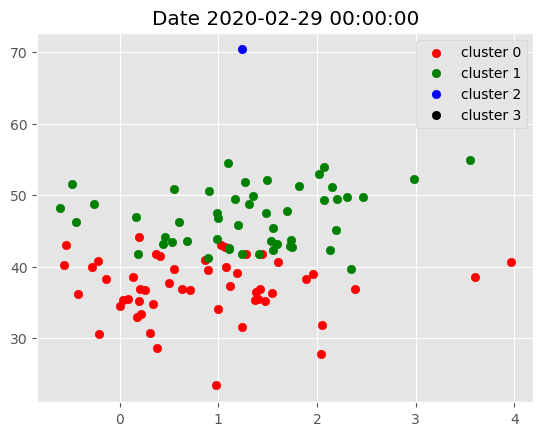

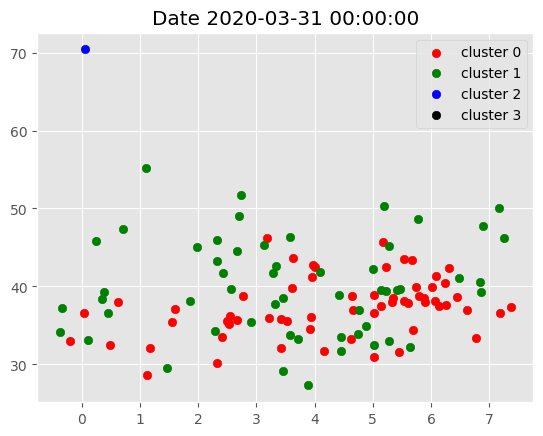

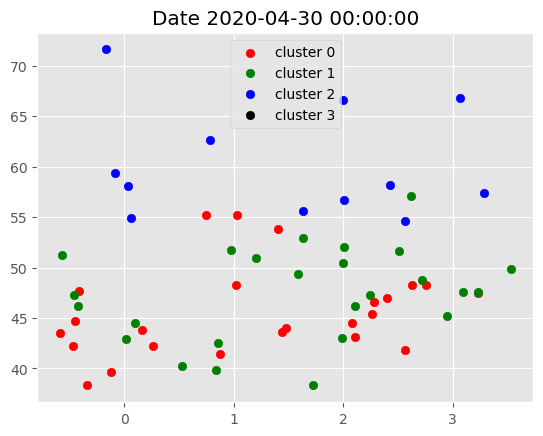

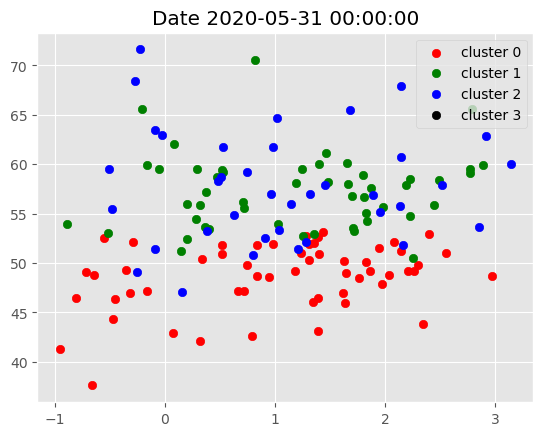

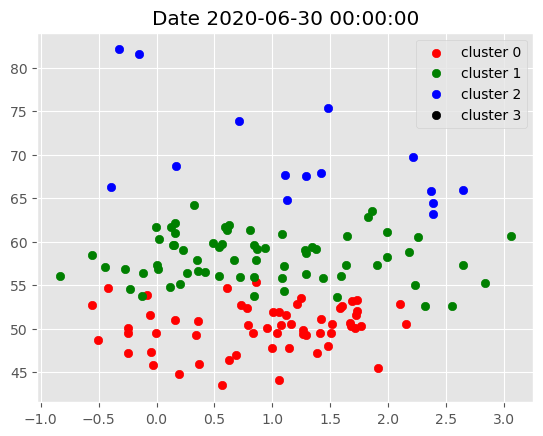

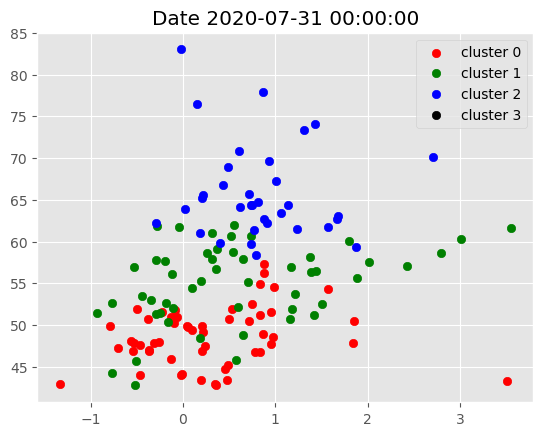

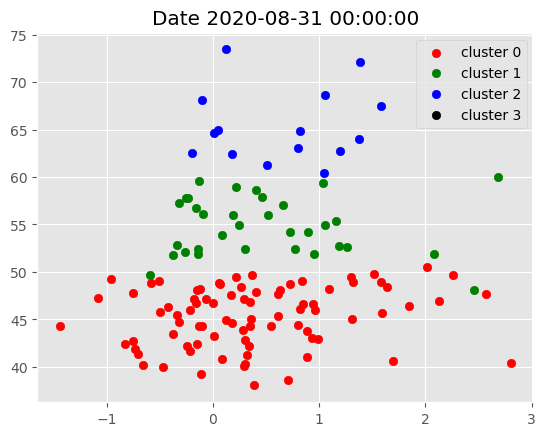

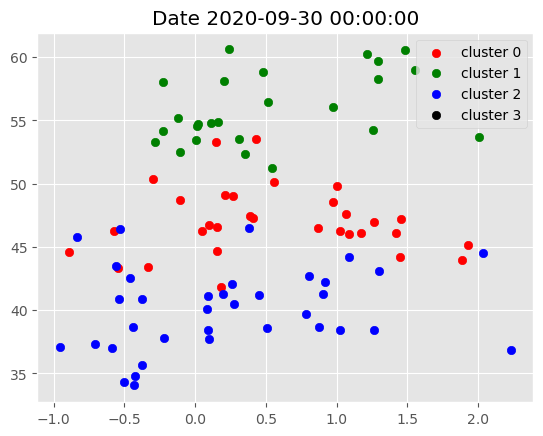

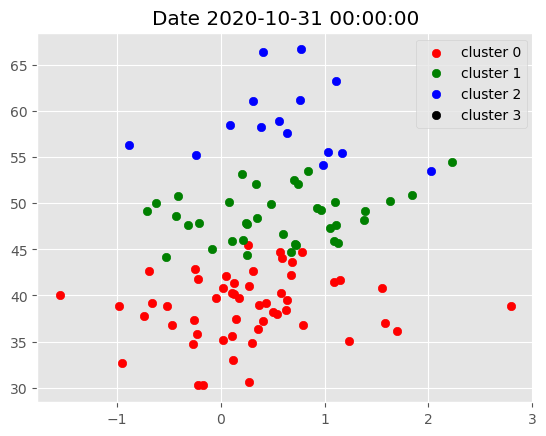

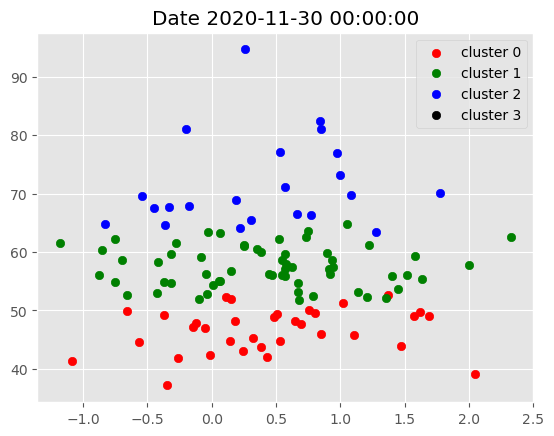

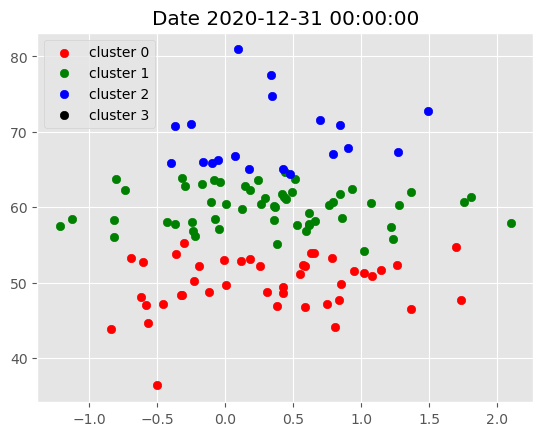

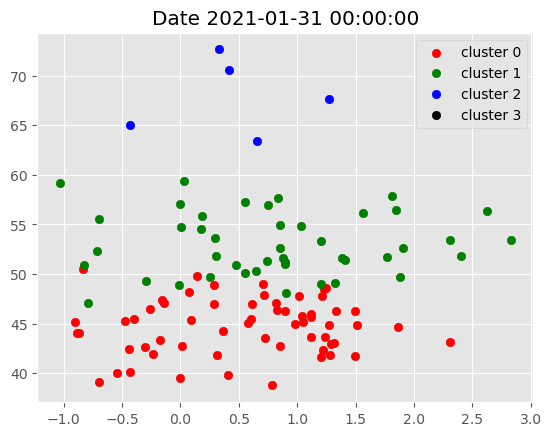

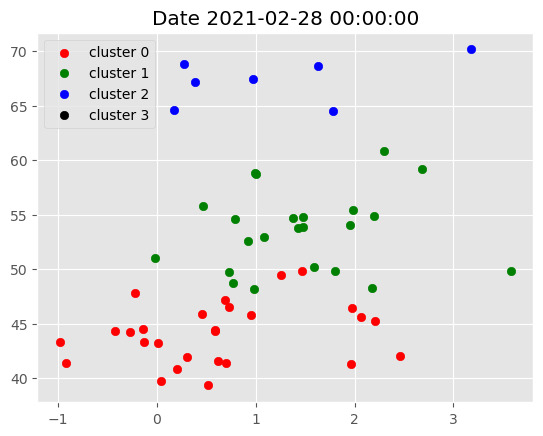

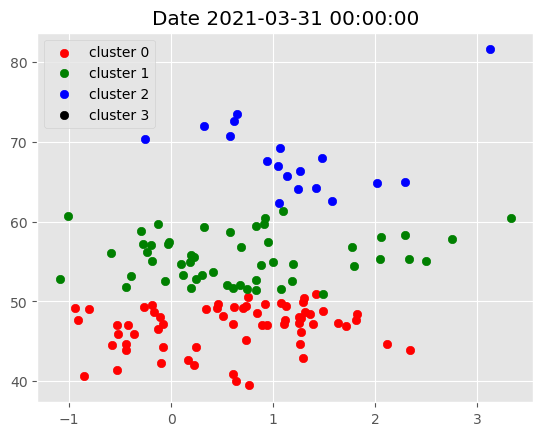

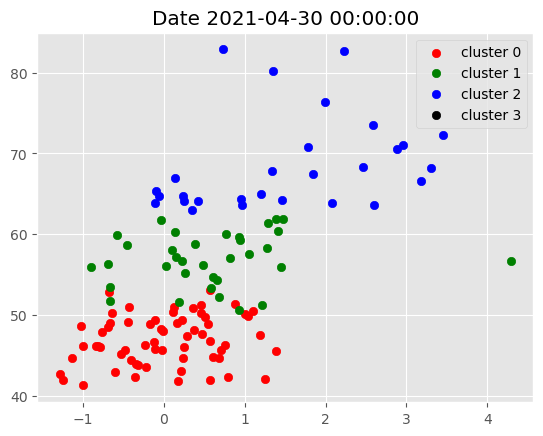

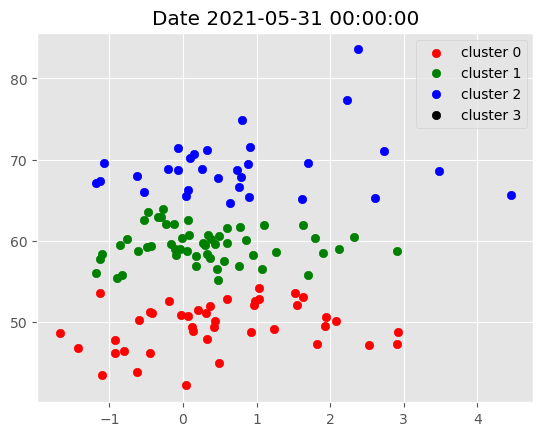

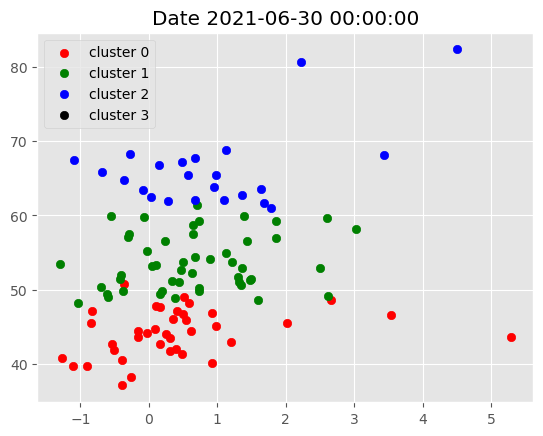

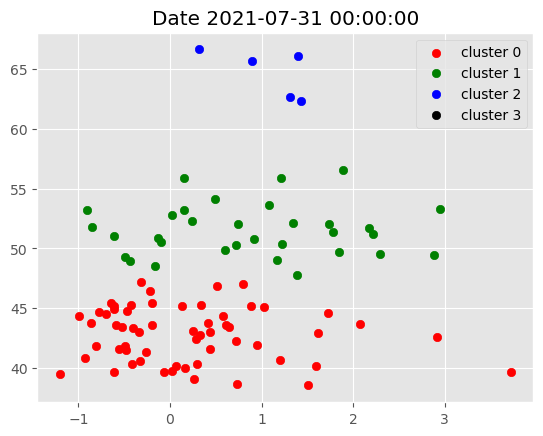

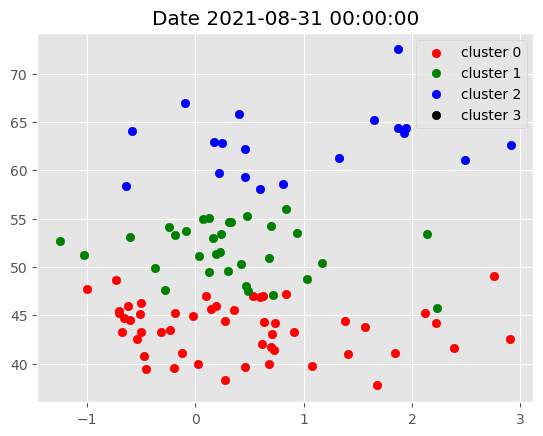

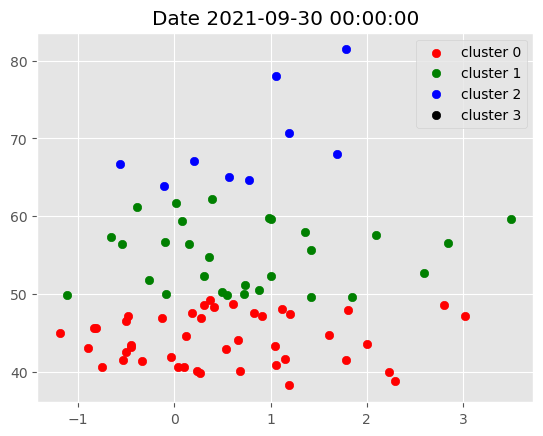

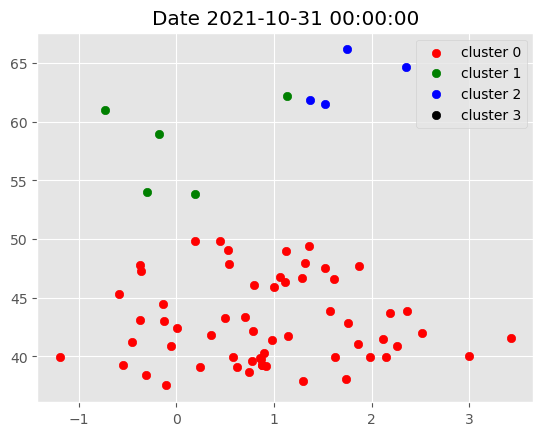

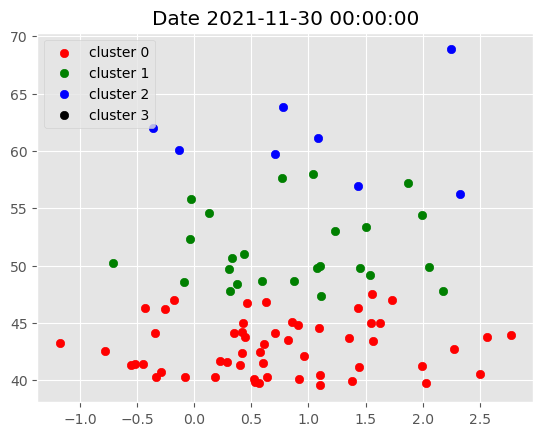

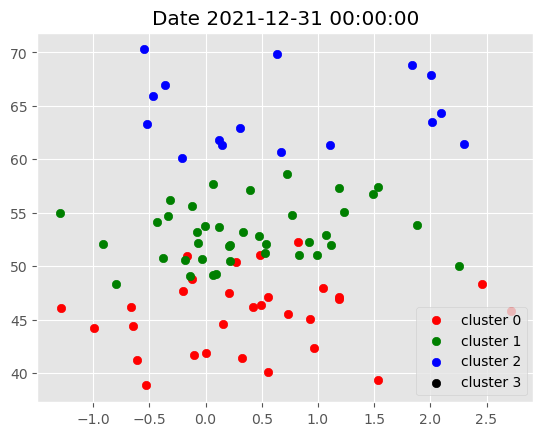

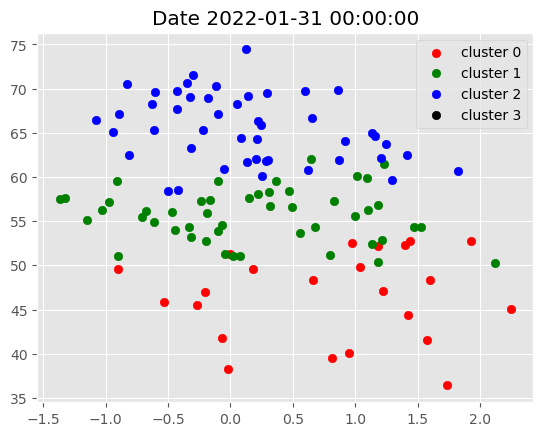

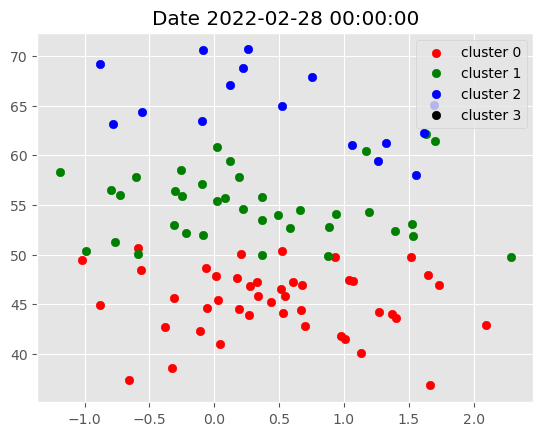

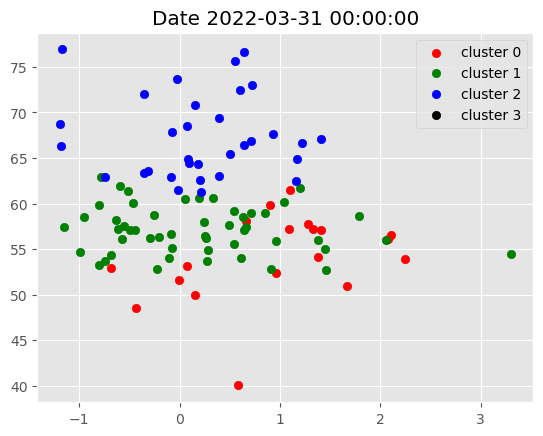

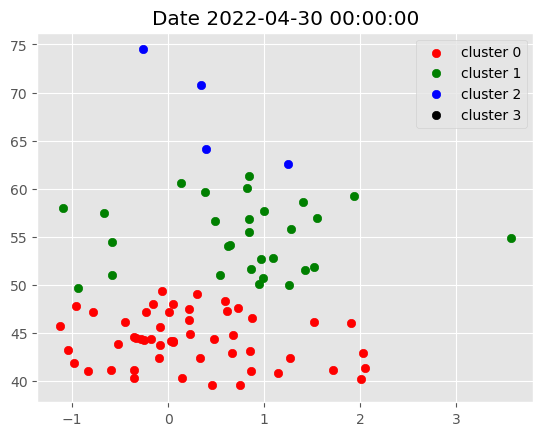

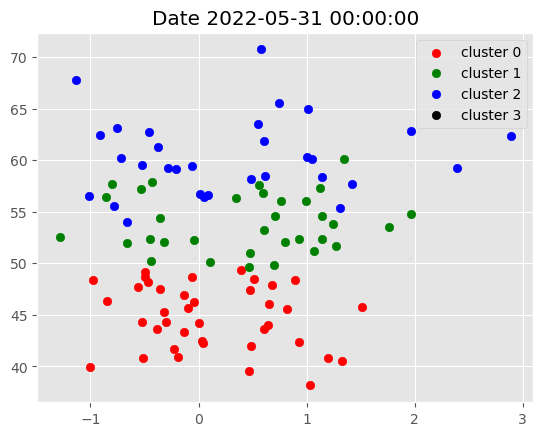

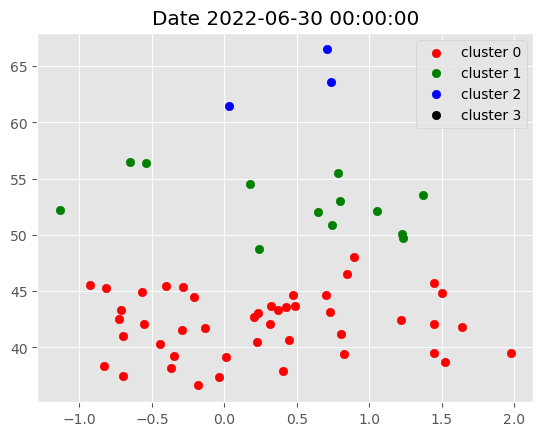

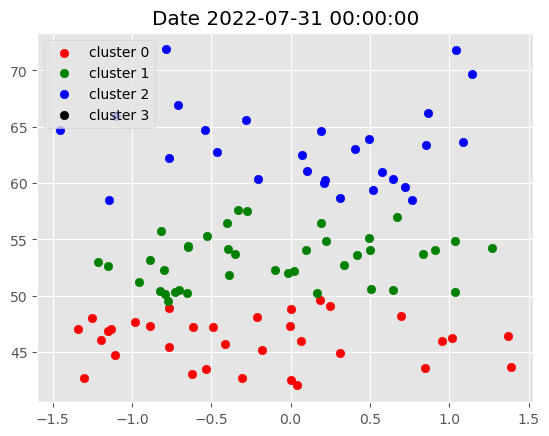

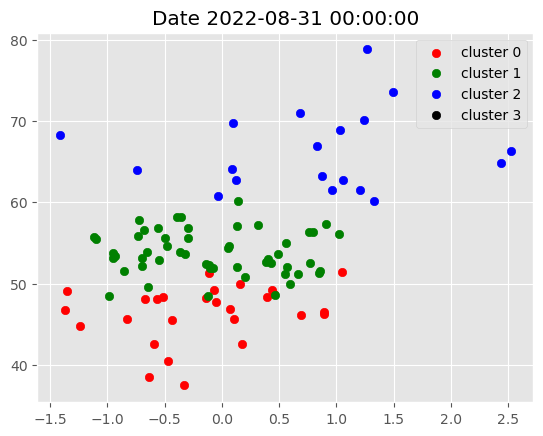

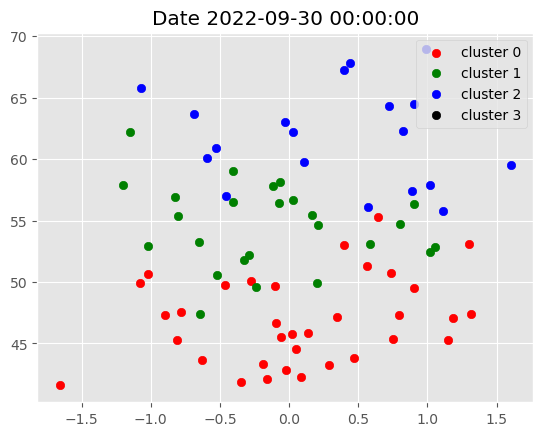

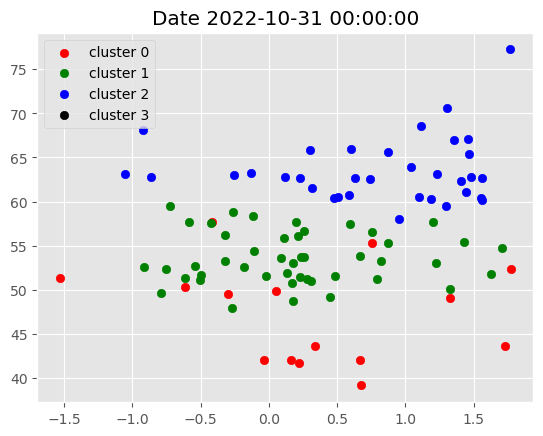

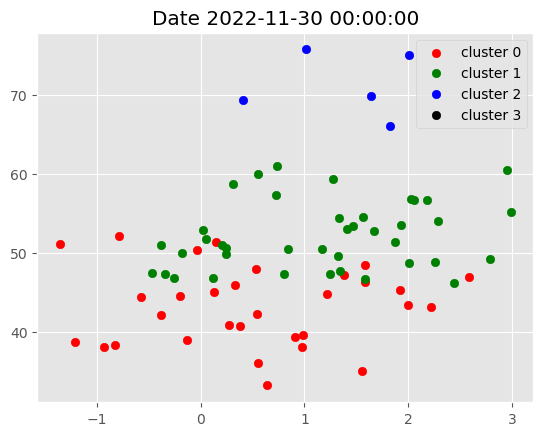

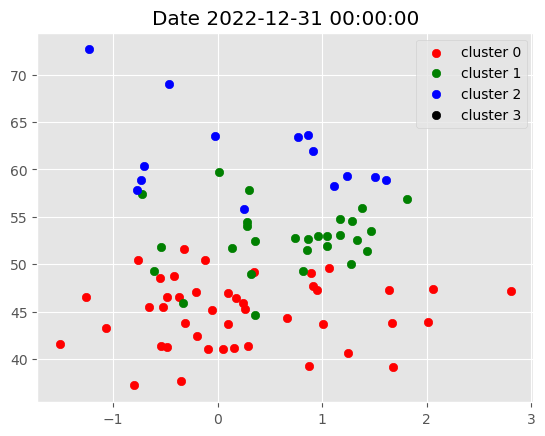

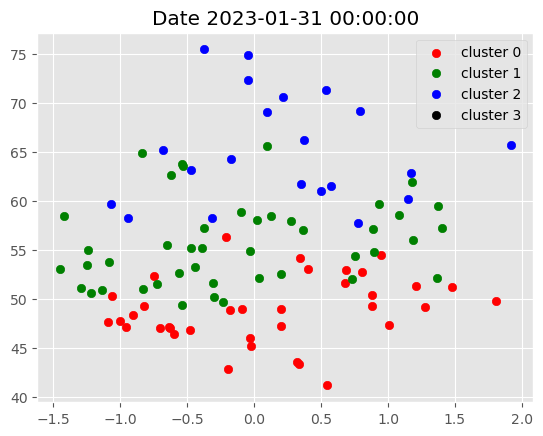

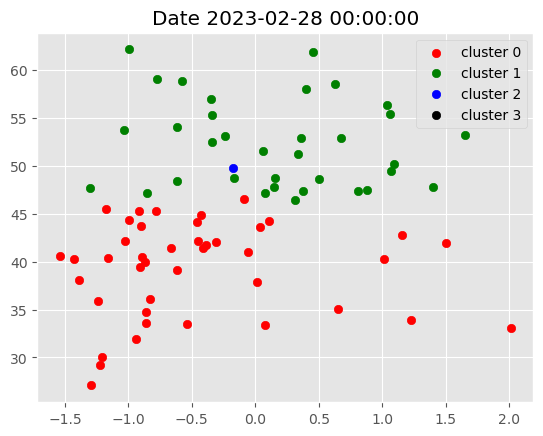

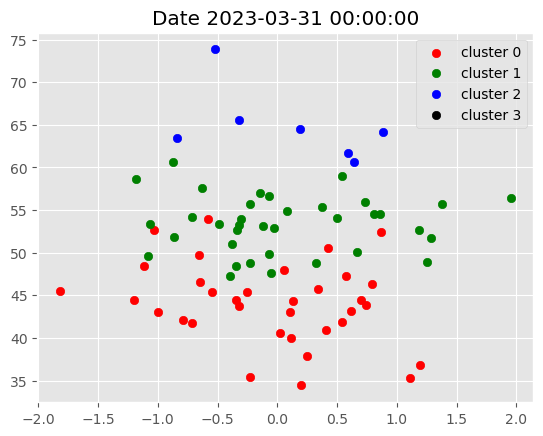

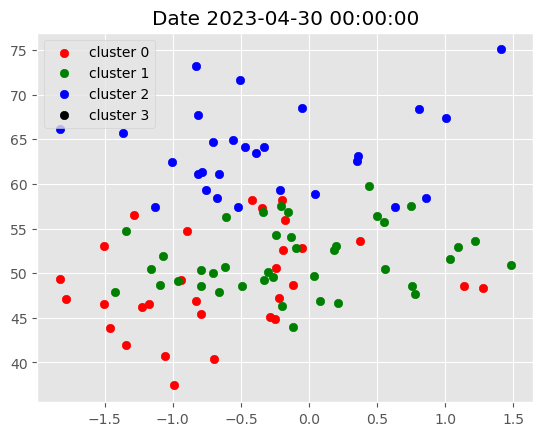

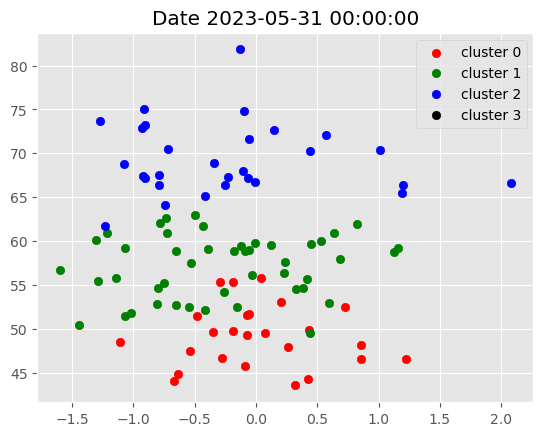

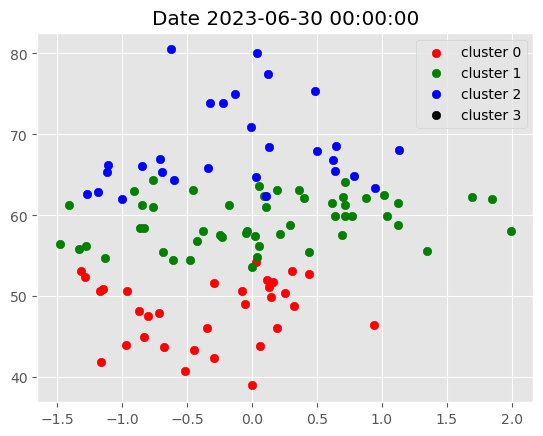

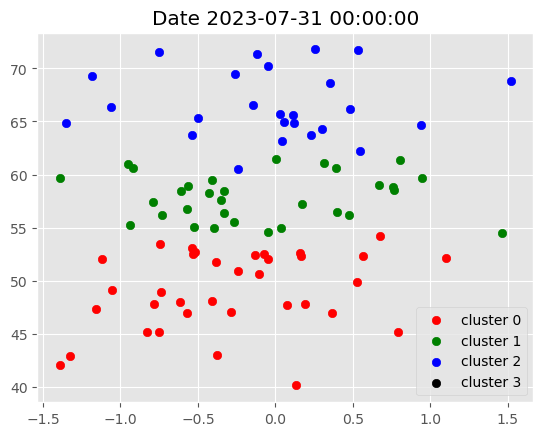

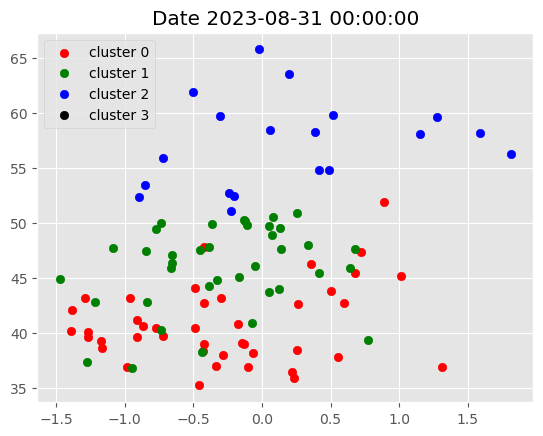

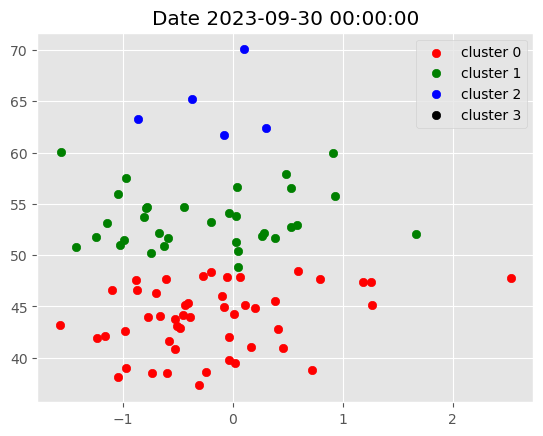

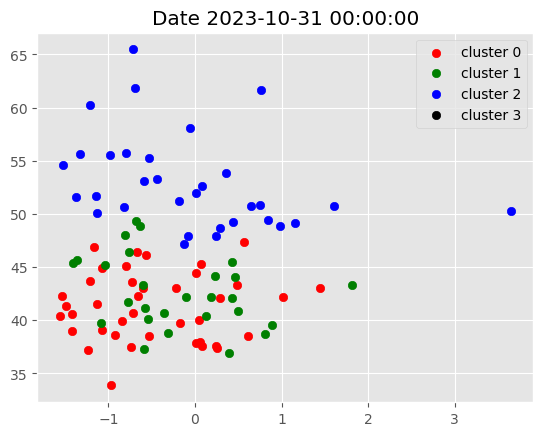

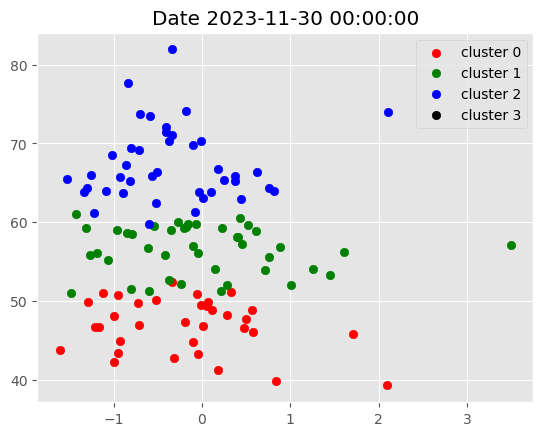

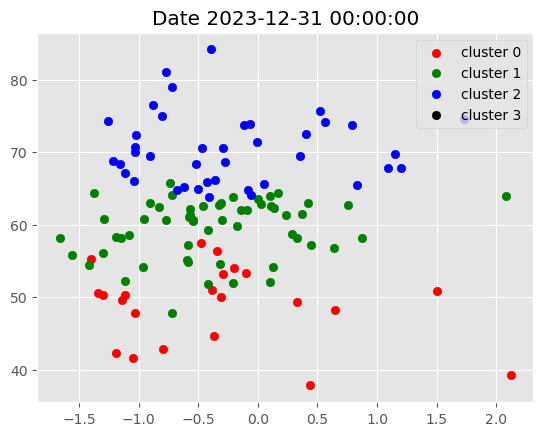

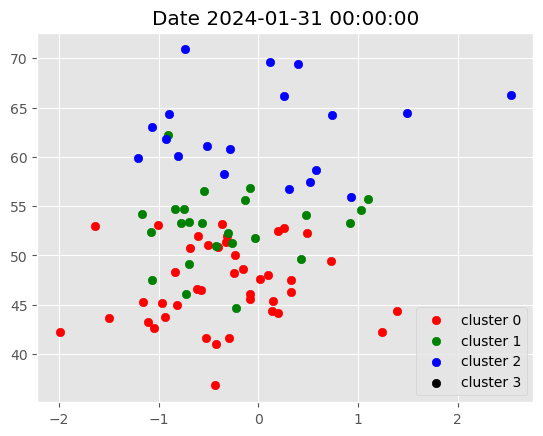

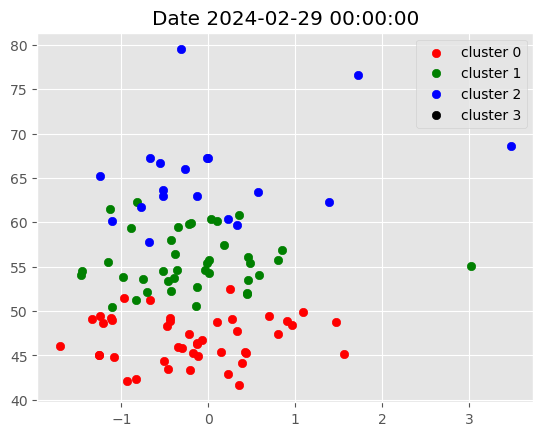

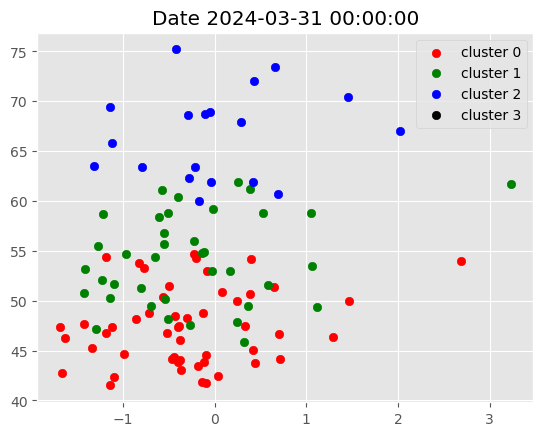

In [157]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plotar_clusters(g)

### Para cada mês, vamos selecionar os ativos baseados em seu cluster e criar um portfólio baseado na otimização da razão Sharpe máxima da Fronteira Eficiente.

In [158]:
# Primeiro, filtraremos apenas as ações correspondentes ao cluster que escolhemos com base em nossa hipótese
# O fator momentum é persistente e minha ideia seria que as ações agrupadas em torno do centróide RSI 70 devem continuar a superar no mês seguinte - 
# assim, eu selecionaria ações correspondentes ao cluster 3.

filtered_df = data[data['cluster'] == 3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2016-04-01': ['ABCB4.SA',
  'ARZZ3.SA',
  'B3SA3.SA',
  'BBDC3.SA',
  'BRAP4.SA',
  'BRSR6.SA',
  'CGAS5.SA',
  'CMIG4.SA',
  'COCE5.SA',
  'CPFE3.SA',
  'CSAN3.SA',
  'CSMG3.SA',
  'CVCB3.SA',
  'DIRR3.SA',
  'ECOR3.SA',
  'EQTL3.SA',
  'EZTC3.SA',
  'FLRY3.SA',
  'GGBR3.SA',
  'GGBR4.SA',
  'GOAU4.SA',
  'GUAR3.SA',
  'HYPE3.SA',
  'JHSF3.SA',
  'MGLU3.SA',
  'MRVE3.SA',
  'MULT3.SA',
  'NEXP3.SA',
  'OSXB3.SA',
  'PETR3.SA',
  'PETR4.SA',
  'PRIO3.SA',
  'RADL3.SA',
  'RENT3.SA',
  'SAPR4.SA',
  'SBSP3.SA',
  'SCAR3.SA',
  'SGPS3.SA',
  'SHOW3.SA',
  'TPIS3.SA',
  'UGPA3.SA'],
 '2016-05-01': ['AMAR3.SA',
  'BRAP4.SA',
  'BRPR3.SA',
  'CCRO3.SA',
  'CEGR3.SA',
  'CGAS5.SA',
  'CSMG3.SA',
  'CSNA3.SA',
  'CVCB3.SA',
  'DASA3.SA',
  'ECOR3.SA',
  'ELET6.SA',
  'EQTL3.SA',
  'FLRY3.SA',
  'HYPE3.SA',
  'LOGN3.SA',
  'MDIA3.SA',
  'MULT3.SA',
  'PETR3.SA',
  'PETR4.SA',
  'SAPR4.SA',
  'SBSP3.SA',
  'SGPS3.SA',
  'SHOW3.SA',
  'TECN3.SA',
  'TGMA3.SA',
  'TRPL4.SA'],
 '2016-06-01': ['A

### Definindo função de otimização do portfólio

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
